In [0]:
!pip install fastai
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install Pillow==4.0.0
!pip install image

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.imports import *
from fastai.conv_learner import *
import pandas as pd
import numpy as np

In [3]:
print("torch.cuda.is_available() = ", torch.cuda.is_available())
print("torch.backends.cudnn.enabled = ", torch.backends.cudnn.enabled )

torch.cuda.is_available() =  True
torch.backends.cudnn.enabled =  True


In [0]:
# Install the Kaggle API
!pip3 install kaggle

# Please Note 


---

Replace ***yourkaggleusername*** and ***yourkagglekey*** with the actual values
in the next step:

```
os.environ["KAGGLE_USERNAME"] = 'yourkaggleusername'
os.environ["KAGGLE_KEY"] = 'yourkagglekey'
```



In [0]:
# Set Environment Variables for Kaggle CLI to use
# username and key can be found in the kaggle.json file

os.environ["KAGGLE_USERNAME"] = 'yourkaggleusername'
os.environ["KAGGLE_KEY"] = 'yourkagglekey'

In [6]:
# List the competetion data/files
!kaggle competitions files -c rsna-pneumonia-detection-challenge

name                                  size  creationDate         
-----------------------------------  -----  -------------------  
GCP Credits Request Link - RSNA.txt    55B  2018-08-27 12:32:43  
stage_1_detailed_class_info.csv        2MB  2018-08-27 12:32:54  
stage_1_sample_submission.csv         52KB  2018-08-27 12:32:54  
stage_1_train_labels.csv               1MB  2018-08-27 12:32:54  
stage_1_test_images.zip              126MB  2018-08-27 12:32:55  
stage_1_train_images.zip               3GB  2018-08-27 12:32:55  


In [0]:
# Download files from kaggle

# -c: competition name# -c: c 
# -f: which file you want to download
# -p: path to where the file are to be saved

!kaggle competitions download -c rsna-pneumonia-detection-challenge -p data/RSNA/

In [8]:
!ls data/RSNA/

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_test_images.zip
stage_1_detailed_class_info.csv.zip	       stage_1_train_images.zip
stage_1_sample_submission.csv		       stage_1_train_labels.csv.zip


In [0]:
!mkdir data/RSNA/zipped/

In [0]:
#**************  This takes a considerable amount of time *****************
# Unzip the .zip file
# -d is the destination

!unzip data/RSNA/stage_1_train_labels.csv.zip -d data/RSNA/
# mv command is used to move files and directories.
# mv command syntax
# mv [options] source dest
!mv data/RSNA/stage_1_train_labels.csv.zip data/RSNA/zipped/

!unzip data/RSNA/stage_1_detailed_class_info.csv.zip -d data/RSNA/
!mv data/RSNA/stage_1_detailed_class_info.csv.zip data/RSNA/zipped/

!unzip data/RSNA/stage_1_train_images.zip -d data/RSNA/train/
!mv data/RSNA/stage_1_train_images.zip data/RSNA/zipped/

!unzip data/RSNA/stage_1_test_images.zip -d data/RSNA/test/
!mv data/RSNA/stage_1_test_images.zip data/RSNA/zipped/

In [0]:
# Install pydicom library

!pip install pydicom

In [0]:
# Patch dataset.py for the ability to handle *.dcm files

import fastai
import fastai.dataset
import pydicom

def isdicom(fn):
    '''True if the fn points to a DICOM image'''
    if fn.endswith('.dcm'):
        return True
    # Dicom signature from the dicom spec.
    with open(fn) as fh:
        fh.seek(0x80)
        return fh.read(4)=='DICM'


def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    elif isdicom(fn):
        slice = pydicom.read_file(fn)
        if slice.PhotometricInterpretation.startswith('MONOCHROME'):
            # Make a fake RGB image
            im = np.stack([slice.pixel_array]*3,-1)
            return im / ((1 << slice.BitsStored)-1)
        else:
            # No support for RGB yet, as it involves various color spaces.
            # It shouldn't be too difficult to add though, if needed.
            raise OSError('Unsupported DICOM image with PhotometricInterpretation=={}'.format(slice.PhotometricInterpretation))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

fastai.dataset.isdicom=isdicom
fastai.dataset.pydicom=pydicom
fastai.dataset.open_image=open_image

In [18]:
!ls data/RSNA/

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_train_labels.csv  zipped
stage_1_detailed_class_info.csv		       test
stage_1_sample_submission.csv		       train


In [19]:
label_csv = 'data/RSNA/stage_1_train_labels.csv'
df_fai = pd.read_csv(label_csv)

# Rewrite the train csv file to contain only two columns as expected by fastai
df_fai[['patientId','Target']].to_csv('train_target_labels.csv',index=False)

label_csv = 'train_target_labels.csv'

df_fai = pd.read_csv(label_csv)
df_fai.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [20]:
PATH = 'data/RSNA/'

sz = 224
f_model = resnet34
bs = 64

n = len(df_fai)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)

data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test', 
                                    val_idxs=val_idxs, 
                                    suffix='.dcm', 
                                    tfms=tfms,
                                    bs=bs)
learn = ConvLearner.pretrained(f_model, data)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 21669324.13it/s]


In [21]:
lrf=learn.lr_find()

 83%|████████▎ | 301/363 [07:50<01:07,  1.09s/it, loss=2.54]

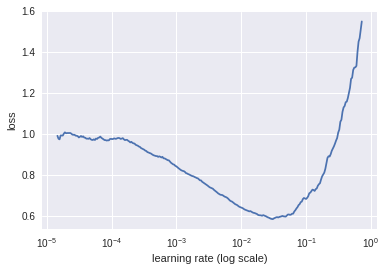

In [22]:
learn.sched.plot()

In [23]:
lr = 0.002
lrs = np.array([lr/9,lr/3,lr])

learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.473784   0.419092   0.808522  
    1      0.41161    0.388868   0.821804  
    2      0.382222   0.38544    0.824564  
    3      0.395901   0.377543   0.824047  
    4      0.382444   0.370627   0.828705  
    5      0.37131    0.368143   0.830602  
    6      0.367595   0.371117   0.83112   


[array([0.37112]), 0.8311195445509024]

In [0]:
learn.save('fastai-rsna-v1')

In [32]:
# In my case the trained model is saved here:
# Please cross check
!ls data/RSNA/models/

fastai-rsna-v1.h5  tmp.h5


In [0]:
from google.colab import files
files.download('data/RSNA/models/fastai-rsna-v1.h5')